In [1]:
import pandas as pd
df = pd.read_csv('SexContact.csv',delimiter=';',skiprows=24,header=None)
# df.columns = ['Column1', 'Column2', 'Column3', 'Column4', 'Column5', 'Column6', 'Column7']
df = df.iloc[:,:3]
df.columns = ['i','j','timestep']
df = df.sort_values(by='timestep')
df.head

<bound method NDFrame.head of            i      j  timestep
0          0      1         0
1          2      1         0
2          3      1         0
3          0      4        21
4          5      6        47
...      ...    ...       ...
50602  15830  16707      2231
50592  14342   4570      2231
50630  16726  16727      2232
50629  16368  10049      2232
50631  16728  16729      2232

[50632 rows x 3 columns]>

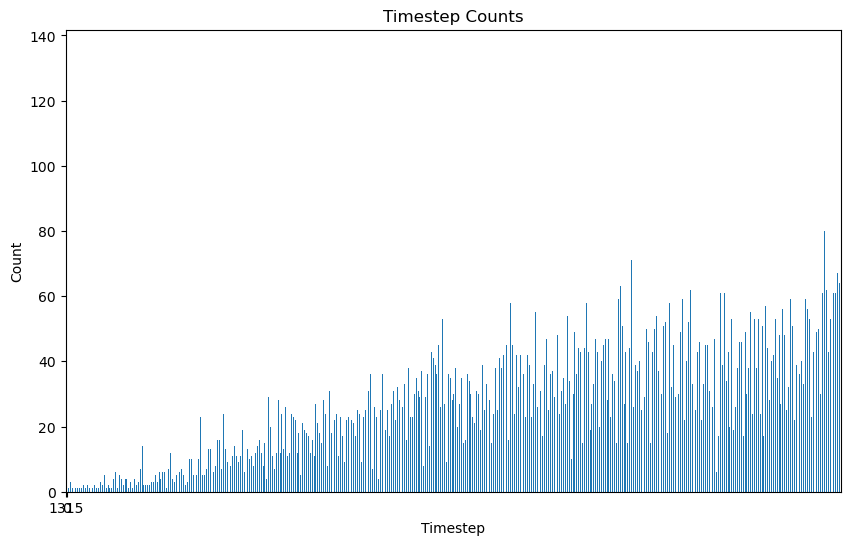

In [2]:
import matplotlib.pyplot as plt
# 使用value_counts函数计算每个timestep的出现次数
timestep_counts = df['timestep'].value_counts()
timestep_counts = timestep_counts.sort_index()

# 创建柱状图
plt.figure(figsize=(10, 6))  # 设置图的大小
# 获取每隔一百个点的timestep值
x_ticks = timestep_counts.index[::1000]
x = list(range(len(x_ticks)))

# 绘制柱状图
timestep_counts.plot(kind='bar', rot=0)
plt.xticks(x, x_ticks)  # 设置x轴刻度为每隔一百个点的timestep值

plt.title('Timestep Counts')  # 设置图的标题
plt.xlabel('Timestep')  # 设置x轴标签
plt.ylabel('Count')  # 设置y轴标签

plt.show()  # 显示图

In [3]:
# 统计 "i" 列中各元素的个数
i_counts = df['i'].nunique()

# 统计 "j" 列中各元素的个数
j_counts = df['j'].nunique()

print('i:' + str(i_counts) + ', j:' + str(j_counts))

i:6624, j:10106


In [4]:
# 获取不同的 "timestep" 值
timestep_values = df['timestep'].unique()

timestep_mapping = {timestep: i + 1 for i, timestep in enumerate(timestep_values)}

# 使用映射字典来替换 "timestep" 列中的值
df['timestep'] = df['timestep'].map(timestep_mapping)

# 创建 "i" 映射字典，将 "i" 映射为从 1 开始的连续整数
unique_i_values = df['i'].unique()
i_mapping = {i: j + 1 for j, i in enumerate(unique_i_values)}

# 使用 "i" 映射字典来替换 "i" 列中的值
df['i'] = df['i'].map(i_mapping)

# 创建 "j" 映射字典，将 "j" 映射为从 71 开始的连续整数
unique_j_values = df['j'].unique()
j_mapping = {j: k + 6625 for k, j in enumerate(unique_j_values)}

# 使用 "j" 映射字典来替换 "j" 列中的值
df['j'] = df['j'].map(j_mapping)

df

,i,j,timestep
0,1,6625,1
1,2,6625,1
2,3,6625,1
3,1,6626,2
4,4,6627,3
...,...,...,...
50602,6213,16728,1914
50592,5546,9629,1914
50630,6623,16729,1915
50629,6455,12950,1915


In [5]:
import numpy as np

In [6]:
# 初始化 SIR 模型状态
individuals_i = list(df['i'].unique())  # 所有个体 i
individuals_j = list(df['j'].unique())  # 所有个体 j

# 合并所有个体，去除重复的标识
individuals = list(set(individuals_i + individuals_j))
individual_states = {individual: 'S' for individual in individuals}
len(individual_states)

16730

In [7]:
def SIR(beta,gamma,df):

    # 模型参数
    beta = 0.5  # 传染率
    gamma = 0.001  # 恢复率
    total_timesteps = len(df['timestep'].unique())  # 总时间步骤

    # 初始化 SIR 模型状态
    individuals_i = list(df['i'].unique())  # 所有个体 i
    individuals_j = list(df['j'].unique())  # 所有个体 j

    # 合并所有个体，去除重复的标识
    individuals = list(set(individuals_i + individuals_j))

    # 随机选择一个个体作为初始感染者
    initial_infected = np.random.choice(individuals, size=1, replace=False)

    # 初始化个体状态字典
    individual_states = {individual: 'S' for individual in individuals}
    individual_states[initial_infected[0]] = 'I'  # 初始感染者
    # individual_states[1] = 'I'
    susceptible = [len(individuals) - 1]  # 初始时刻，除初始感染者外的所有个体都是易感者
    infected = [1]  # 初始时刻，一个个体处于感染状态
    recovered = [0]  # 初始时刻，没有个体处于康复状态


    # 模拟 SIR 模型在每个时间步骤的演化
    for timestep in range(1, total_timesteps):
        new_infected = 0
        new_recovered = 0

        # 计算每个时间步骤内的新感染者和新康复者
        contacts_at_timestep = df[df['timestep'] == timestep]
        for _, contact in contacts_at_timestep.iterrows():
            if individual_states[contact['i']] == 'I':
                # print('individual infected -1 ')
                # i 感染了 j
                if individual_states[contact['j']] == 'S' and np.random.rand() < beta:
                    new_infected += 1
                    individual_states[contact['j']] = 'I'
            elif individual_states[contact['i']] == 'S':
                # i 与 j 接触，可能被感染
                # print('individual infected -2')
                if individual_states[contact['j']] == 'I' and np.random.rand() < beta:
                    individual_states[contact['i']]  = 'I'
                    new_infected += 1

        # 恢复
        for individual in individuals:
            if individual_states[individual] == 'I' and np.random.rand() < gamma:
                new_recovered += 1
                individual_states[individual] = 'R'

        # 更新 SIR 模型状态
        susceptible.append(max(susceptible[-1] - new_infected, 0))
        infected.append(max(infected[-1] + new_infected - new_recovered, 0))
        recovered.append(recovered[-1] + new_recovered)

    # 绘制 SIR 模型的状态演化图
    # plt.figure(figsize=(10, 6))
    # plt.plot(range(total_timesteps), susceptible, label='Susceptible')
    # plt.plot(range(total_timesteps), infected, label='Infected')
    # plt.plot(range(total_timesteps), recovered, label='Recovered')
    # plt.xlabel('Time')
    # plt.ylabel('Number of Individuals')
    # plt.title('SIR Model Simulation')
    # plt.legend()
    # plt.show()
    total_num = infected[-1] + recovered[-1]
    # print(susceptible)
    result = [individual_states,total_num,initial_infected[0]]
    return result

In [8]:
# import multiprocessing
# from functools import partial
# import threading
# #返回值依次为 [每个节点状态(字典)，I+R 总数，0号病人]
# exp_result = []
# beta = 0.5
# gamma = 0.001
# for i in range(100):
#     res = SIR(beta,gamma,df)
#     exp_result.append(res)
#     print('experiment ' + str(i) + ' is done.')
#
#

In [9]:
# import seaborn as sns
# IR = [result[1] for result in exp_result]
# IR
#

In [10]:
# # 使用 seaborn 绘制概率密度图
# # 使用Seaborn绘制概率密度图
# sns.kdeplot(IR,common_norm=True,cut=0,fill=True)  # 设置 bins 参数来控制直方图的柱子数量
#
# # 设置图的标题和标签
# plt.title("Probability Density Plot")
# plt.xlabel("I+R")
# plt.ylabel("Density")
#
# # 显示图
# plt.show()

In [15]:
# 创建一个DataFrame或列表来存储结果
import random
import concurrent.futures
from sir_simulation import SIR1
from tqdm import tqdm
results = []

# 定义参数
beta = 0.8
gamma = 0.01
# df 是你的数据帧

num_simulations = 100
total_timesteps = len(df['timestep'].unique())  # 总时间步骤
time = random.randint(1, 1000)

progress = tqdm(total=num_simulations)

# 使用4个核心并行运行SIR函数
with concurrent.futures.ProcessPoolExecutor(max_workers=8) as executor:
    futures = []
    for _ in range(num_simulations):
        future = executor.submit(SIR1, beta, gamma, df,time)
        future.add_done_callback(lambda p:progress.update(1))
        futures.append(future)
    concurrent.futures.wait(futures)

    # 获取每个模拟的结果
    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        results.append(result)

# 将结果转换为DataFrame
results_df = pd.DataFrame(results, columns=["final_state", "attack_num", "patient_zero"])
print('over')
# 现在，你可以对 results_df 进行分析和可视化


100%|██████████| 100/100 [01:11<00:00,  1.39it/s]

100%|██████████| 100/100 [00:29<00:00,  4.92it/s]

over


In [16]:
results_df

,final_state,attack_num,patient_zero
0,"{1: 'S', 2: 'S', 3: 'S', 4: 'S', 5: 'S', 6: 'S...",2,9469
1,"{1: 'R', 2: 'R', 3: 'S', 4: 'S', 5: 'S', 6: 'R...",2832,8804
2,"{1: 'R', 2: 'R', 3: 'S', 4: 'S', 5: 'S', 6: 'R...",2377,9833
3,"{1: 'R', 2: 'R', 3: 'S', 4: 'S', 5: 'S', 6: 'R...",2322,1673
4,"{1: 'S', 2: 'R', 3: 'S', 4: 'S', 5: 'S', 6: 'R...",2369,9833
...,...,...,...
95,"{1: 'S', 2: 'S', 3: 'S', 4: 'S', 5: 'S', 6: 'S...",1,9952
96,"{1: 'S', 2: 'R', 3: 'S', 4: 'S', 5: 'S', 6: 'R...",2661,1441
97,"{1: 'S', 2: 'S', 3: 'S', 4: 'S', 5: 'S', 6: 'S...",1,7894
98,"{1: 'S', 2: 'S', 3: 'S', 4: 'S', 5: 'S', 6: 'S...",5,973


In [13]:
# 使用条件过滤筛选 patient_zero 为 2127 的行
# filtered_rows = results_df[results_df["patient_zero"] == 2127]
# filtered_dict = filtered_rows.iloc[0,0]
# filtered_dict[2127]
# 遍历筛选后的行并获取 final_state 中对应的值
# for index, row in filtered_rows.iterrows():
#     final_state_value = row["final_state"]
#     result_value = results[index]["key1"]  # 获取 final_state 中对应的值
#     print(f"Row {index} - patient_zero: {row['patient_zero']}, final_state value: {final_state_value}, corresponding result: {result_value}")

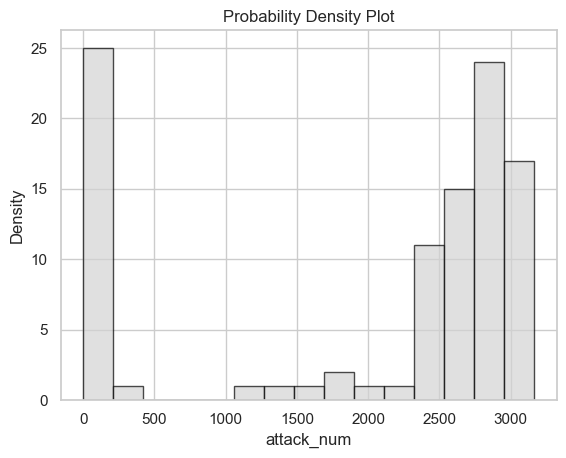

In [17]:
import seaborn as sns

# 使用 seaborn 绘制概率密度图
sns.set(style="whitegrid")
# sns.histplot(results_df["attack_num"], kde=True, color="skyblue", bins=15, element="step")

# 绘制柱状图
plt.hist(results_df["attack_num"], bins=15, color="lightgray", edgecolor="black", alpha=0.7)
# plt.hist(results_df["attack_num"], bins=20, color="skyblue", edgecolor="black")

# 设置图的标题和标签
plt.title("Probability Density Plot")
plt.xlabel("attack_num")
plt.ylabel("Density")

# 显示图
plt.show()

In [20]:
list_of_dicts = results_df['final_state'].tolist()

[{1: 'S',
  2: 'S',
  3: 'S',
  4: 'S',
  5: 'S',
  6: 'S',
  7: 'S',
  8: 'S',
  9: 'S',
  10: 'S',
  11: 'S',
  12: 'S',
  13: 'S',
  14: 'S',
  15: 'S',
  16: 'S',
  17: 'S',
  18: 'S',
  19: 'S',
  20: 'S',
  21: 'S',
  22: 'S',
  23: 'S',
  24: 'S',
  25: 'S',
  26: 'S',
  27: 'S',
  28: 'S',
  29: 'S',
  30: 'S',
  31: 'S',
  32: 'S',
  33: 'S',
  34: 'S',
  35: 'S',
  36: 'S',
  37: 'S',
  38: 'S',
  39: 'S',
  40: 'S',
  41: 'S',
  42: 'S',
  43: 'S',
  44: 'S',
  45: 'S',
  46: 'S',
  47: 'S',
  48: 'S',
  49: 'S',
  50: 'S',
  51: 'S',
  52: 'S',
  53: 'S',
  54: 'S',
  55: 'S',
  56: 'S',
  57: 'S',
  58: 'S',
  59: 'S',
  60: 'S',
  61: 'S',
  62: 'S',
  63: 'S',
  64: 'S',
  65: 'S',
  66: 'S',
  67: 'S',
  68: 'S',
  69: 'S',
  70: 'S',
  71: 'S',
  72: 'S',
  73: 'S',
  74: 'S',
  75: 'S',
  76: 'S',
  77: 'S',
  78: 'S',
  79: 'S',
  80: 'S',
  81: 'S',
  82: 'S',
  83: 'S',
  84: 'S',
  85: 'S',
  86: 'S',
  87: 'S',
  88: 'S',
  89: 'S',
  90: 'S',
  91: 'S',
  92: 'S

In [24]:
state_one_hot = []
for dict in list_of_dicts:
    one_hot_encoding = []
    for key, value in dict.items():
        if value == 'S':
            one_hot_encoding.append([1, 0, 0])
        elif value == 'I':
            one_hot_encoding.append([0, 1, 0])
        elif value == 'R':
            one_hot_encoding.append([0, 0, 1])
        else:
            raise ValueError("Invalid value in the dictionary")
    state_one_hot.append(one_hot_encoding)

100

In [27]:
len(state_one_hot)


100